In [1]:
import torch
import clip
from PIL import Image
import json
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import os 
import imageio
import matplotlib.pyplot as plt
import json

/root/anaconda3/envs/hw3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### DATASET: Notice that inference code doea not have label!

In [2]:
class HW3_1_Dataset(Dataset):
    def __init__(self, path, tfm = None ,files = None):
        super(HW3_1_Dataset).__init__()
        self.path = path
        self.files = [os.path.join(path,x) for x in os.listdir(path) if x.endswith(".png")]
        #self.files = random.sample(self.files, len(self.files))
        if files != None:
            self.files = files
        #print(f"One {path} sample",self.files[0]) 
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
    
    def __filename__(self,idx):
        return self.files[idx].split('/')[-1]
    
    def __getitem__(self,idx):
        fname = self.files[idx]
        #read image
        im = np.array(imageio.v2.imread(fname))
        im = Image.fromarray(im)
        #im = torch.from_numpy(im).permute(2,0,1)
        #transform
        if self.transform != None:
            im = self.transform(im)
        label = int(fname.split('/')[-1].split('_')[0])
        return im, label

### Read json and create dataset

In [3]:
with open('../hw3_data/p1_data/id2label.json', newline='') as jsonfile:
    id2label = json.load(jsonfile)
    print(id2label)

{'0': 'bicycle', '1': 'chair', '2': 'camel', '3': 'rabbit', '4': 'lamp', '5': 'clock', '6': 'forest', '7': 'fox', '8': 'porcupine', '9': 'bed', '10': 'baby', '11': 'dinosaur', '12': 'skyscraper', '13': 'willow_tree', '14': 'apple', '15': 'raccoon', '16': 'skunk', '17': 'kangaroo', '18': 'oak_tree', '19': 'worm', '20': 'beetle', '21': 'wardrobe', '22': 'possum', '23': 'pine_tree', '24': 'house', '25': 'wolf', '26': 'rose', '27': 'bee', '28': 'dolphin', '29': 'woman', '30': 'mushroom', '31': 'television', '32': 'bus', '33': 'mouse', '34': 'castle', '35': 'boy', '36': 'lizard', '37': 'sweet_pepper', '38': 'mountain', '39': 'palm_tree', '40': 'couch', '41': 'girl', '42': 'cup', '43': 'crab', '44': 'elephant', '45': 'lion', '46': 'streetcar', '47': 'otter', '48': 'shrew', '49': 'sunflower'}


In [4]:
_dataset_dir = '../hw3_data/p1_data/'
val_set = HW3_1_Dataset(os.path.join(_dataset_dir,'val'), tfm=None)

### Evaluate

In [6]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

model.eval()
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in list(id2label.values())]).to(device)
#text_inputs = torch.cat([clip.tokenize(f"No {c}, no score") for c in list(id2label.values())]).to(device)

correct = 0

for i, data in tqdm(enumerate(val_set), total=len(val_set)):
    
    image, label = data
    image_input = preprocess(image).unsqueeze(0).to(device)
    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    #values, indices = similarity[0].topk(5)
    values, indices = similarity[0].topk(1)

    if label == indices[0]:
        correct += 1
#compute accuracy
epoch_acc = 100. * (correct / len(val_set))
print('-'*5+'Zero-shot complete'+'-'*5)
print('accuracy', epoch_acc)

100%|██████████| 2500/2500 [01:08<00:00, 36.64it/s]


-----Zero-shot complete-----
accuracy 71.12


## Report Visualization

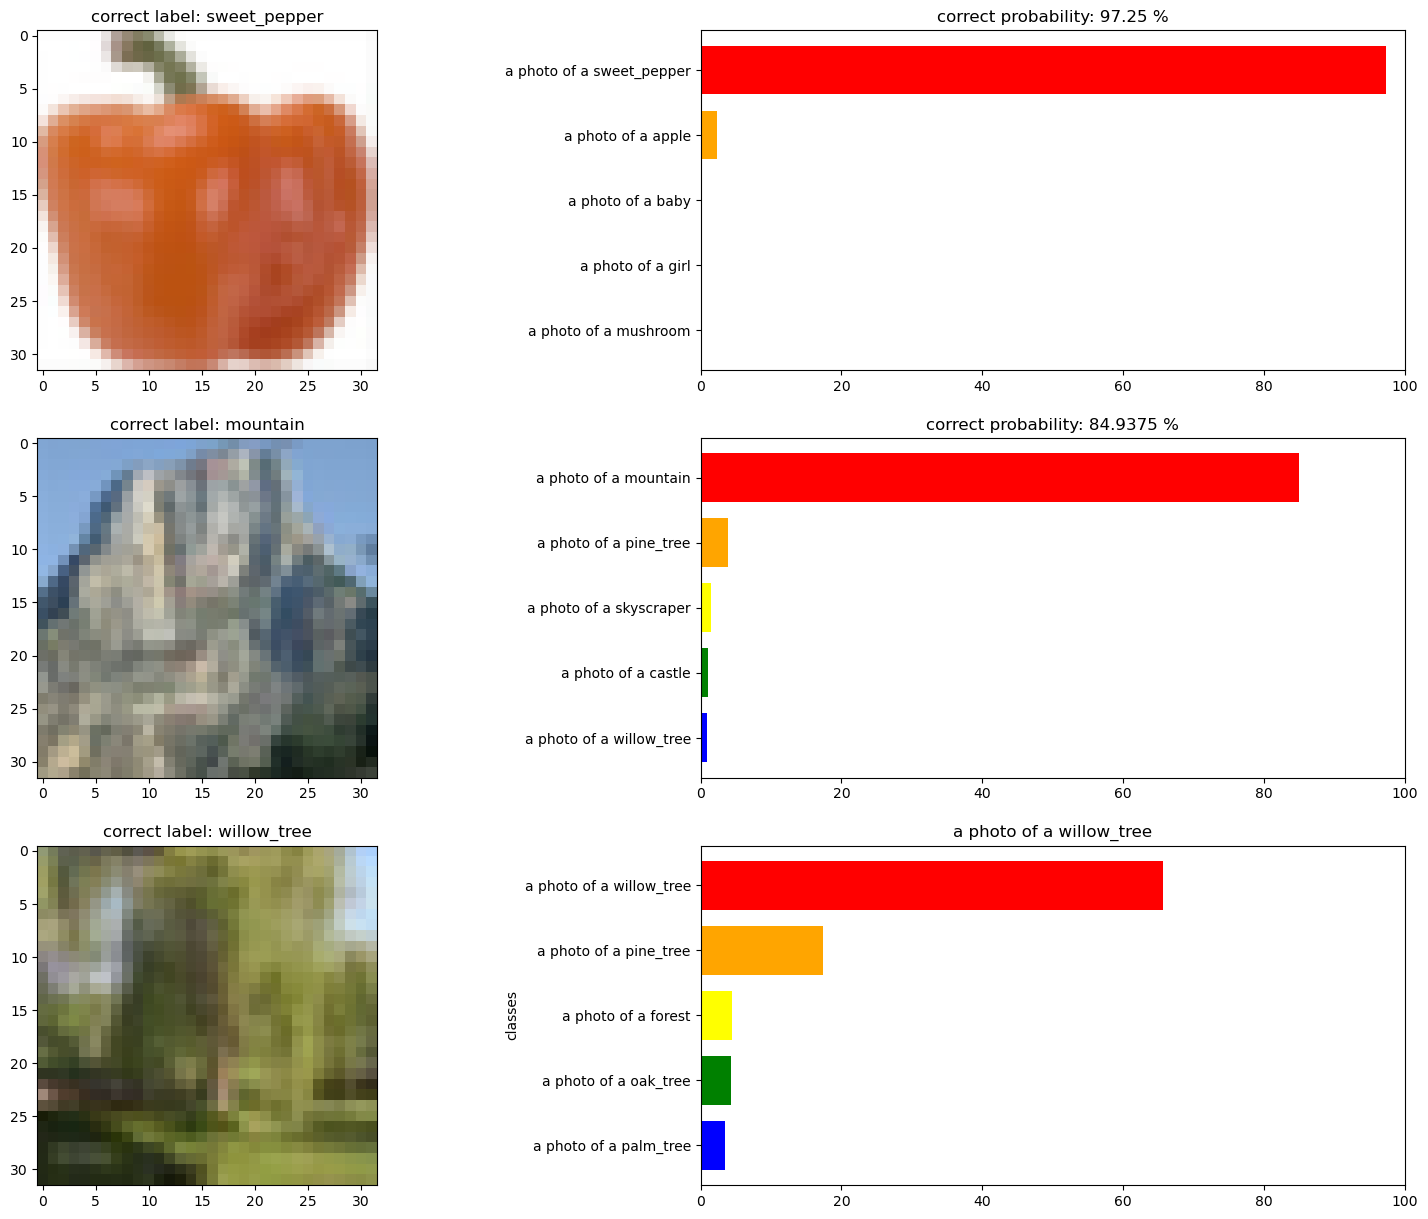

In [11]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

model.eval()
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in list(id2label.values())]).to(device)
correct = 0


rand_idx = torch.randint(0,len(val_set),(3,))
num=0
#fig = plt.figure(figsize=(10,20))
fig, ax = plt.subplots(3,2)
fig.set_size_inches(20, 15)
for i, idx in enumerate(rand_idx):
    
    image, label = val_set[idx]
    image_input = preprocess(image).unsqueeze(0).to(device)
    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)
    
    ax[i,0].imshow(image)
    ax[i,0].set_title(f'correct label: {id2label[str(label)]}')
    width = 0.75 # the width of the bars
    x = [f'a photo of a {id2label[str(k)]}' for k in indices.cpu().numpy()]
    y = list(np.round(100*values.cpu().numpy(), 2))
 
    ax[i,1].barh(x[::-1], y[::-1], width, color=['blue' , 'green', 'yellow', 'orange', 'red'], align='center')
    ax[i,1].set_title(f'correct probability: {y[0]} %')
    ax[i,1].set_xlim(0,100)
    #ax.set_yticklabels(x, minor=False)
    plt.margins(0,0.05)
    plt.title(f'a photo of a {id2label[str(label)]}')
    plt.ylabel('classes')
    num+=1
    
plt.savefig('./outputs/problem.png')    
plt.show()